In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re
import numpy as np

cores = 4

In [2]:
tweets_with_originals = pd.read_csv('tweets_with_originals.csv', parse_dates = ['tweet_created'])

In [3]:
tweets_with_originals['text_clean'] = tweets_with_originals.text_clean.str.replace(r'@(\w+)([\s.,:;!])?', r'\1 ') # remove @s in @mentions

In [4]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import string
#stopwords = stopwords.union(set([i for i in string.punctuation])) # remove punctuation
#stopwords = stopwords.union(set(['AmericanAir', 'United', 'USAirways', 'JetBlue', 'SouthwestAir', 'Delta', 'VirginAmerica']))

In [5]:
tweets_with_originals.loc[55].text_clean

"VirginAmerica hi! i'm so excited about your $99 LGA->DAL deal- but i've been trying 2 book since last week & the page never loads. thx!"

# TF-IDF to identify additional stopwords 

Using TF-IDF, we'll look for additional stopwords 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10)
tweet_input = tweets_with_originals.text_clean
# maybe try to take out numbers, prices 
tweet_input=tweet_input.str.replace(r" (\d|\W)+","") # remove digits, nonword things
T = tfidf_vectorizer.fit_transform(tweet_input) # these are our features

In [7]:
idf_df = pd.DataFrame(index = tfidf_vectorizer.get_feature_names())
idf_df['idf_vals']= tfidf_vectorizer.idf_
idf_df.describe()

,idf_vals
count,1628.000000
mean,7.120723
std,0.958025
min,2.421465
25%,6.609403
50%,7.360819
75%,7.871644
max,8.181799


The minimum inverse document frequency is not so low. For our first pass I won't add any stopwords based on IDF values. 

We can use this array of tfidf vectors as input features... for testing purposes we'll also allow 2-grams and 3-grams to see if this improves the result. 

In [8]:
tf2_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,2))
tf3_vectorizer = TfidfVectorizer(stop_words = stopwords, strip_accents = 'unicode', min_df = 10, ngram_range = (1,3))
T_2 = tf2_vectorizer.fit_transform(tweet_input) 
T_3 = tf3_vectorizer.fit_transform(tweet_input)

tfidf_input_mats = [T, T_2, T_3]

# Word2Vec Model 

First we'll train a word2vec model on our tweets and see what sorts of words are grouped together. 

In [83]:
from nltk.tokenize.casual import TweetTokenizer
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
cores = 4 # depends on how many cores you have...

tokenizer = TweetTokenizer(preserve_case=False)
tokenized_input = [tokenizer.tokenize(tweet) for tweet in tweet_input.values]
tokenized_input = [[word for word in tweet if word not in string.punctuation] for tweet in tokenized_input]
model_word2vec = Word2Vec(tokenized_input, window=5, min_count=10, workers=cores) # build vocabulary

model_word2vec.train(tokenized_input, total_examples=len(tokenized_input), epochs=10)
model_word2vec.save('airlinetweet_word2vec.model')

The results look ok, airlines are associated with other airlines...

In [84]:
model_word2vec.wv.most_similar('united')

/conda/envs/nlp/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('jetblue', 0.8555155992507935),
 ('americanair', 0.8235585689544678),
 ('southwestair', 0.7941441535949707),
 ('usairways', 0.7848982810974121),
 ('virginamerica', 0.6322903037071228),
 ('however', 0.5049555897712708),
 ('mind', 0.4988018274307251),
 ('that', 0.4783726632595062),
 ('know', 0.4579315781593323),
 ('guess', 0.4573063254356384)]

In [85]:
model_word2vec.wv.most_similar('usairways')

[('americanair', 0.8479862213134766),
 ('united', 0.7848982810974121),
 ('southwestair', 0.7254579067230225),
 ('jetblue', 0.7034142017364502),
 ('virginamerica', 0.4963826835155487),
 ('mind', 0.4693787693977356),
 ('reservations', 0.46644100546836853),
 ('already', 0.44885408878326416),
 ('worries', 0.42794811725616455),
 ('guess', 0.42589789628982544)]

And TSA with security check type things

In [86]:
model_word2vec.wv.most_similar('tsa')

[('pre', 0.8531556129455566),
 ('correct', 0.7531304955482483),
 ('file', 0.7516837120056152),
 ('res', 0.7468122243881226),
 ('name', 0.7446273565292358),
 ('receipt', 0.7026339769363403),
 ('number', 0.6914547681808472),
 ('uk', 0.6902579069137573),
 ('states', 0.6901673078536987),
 ('cc', 0.6896678805351257)]

## Doc2Vec Model

Doc2Vec learns "document" vectors instead of word vectors. We view each tweet as a document

In [14]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
sentiment_tweets_docs = [TaggedDocument(tokenized_input[i], [str(tweets_with_originals.tweet_id.iloc[i])]) for i in range(tweet_input.shape[0])]

In [15]:
model_doc2vec = Doc2Vec(dm=1, vector_size=300, hs=1, window=5,
                        min_count=10, sample=0, epochs=20, alpha = .4, 
                        workers=cores, dbow_words = 1)
model_doc2vec.build_vocab(sentiment_tweets_docs)
model_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs = 20)
model_doc2vec.save('airlinetweet_doc2vec.model')

In [16]:
model_doc2vec.wv.most_similar('late')

[('seattle', 0.839514970779419),
 ('come', 0.831027626991272),
 ('big', 0.822252094745636),
 ('trying', 0.8195838332176208),
 ('opportunity', 0.809916615486145),
 ('treat', 0.7907835245132446),
 ('lauderdale', 0.7852464914321899),
 ('bad', 0.78386390209198),
 ('”', 0.7835196256637573),
 ('party', 0.7803313136100769)]

In [17]:
model_doc2vec.wv.most_similar('delay')

[('tag', 0.8901811838150024),
 ('sfo', 0.8805761337280273),
 ('recent', 0.8748871088027954),
 ('speaking', 0.8659912347793579),
 ('read', 0.8624579906463623),
 ('flightto', 0.8591439723968506),
 ('calling', 0.8585244417190552),
 ('sw', 0.8562990427017212),
 ('a', 0.8460516929626465),
 ('try', 0.8434302806854248)]

In [18]:
model_doc2vec.wv.most_similar('tsa')

[('train', 0.865645170211792),
 ('large', 0.83207106590271),
 ('over', 0.8133547306060791),
 ('page', 0.8122539520263672),
 ('located', 0.8078713417053223),
 ('interview', 0.8073971271514893),
 ('wont', 0.8068068027496338),
 ('same', 0.8001067042350769),
 ('son', 0.7959269285202026),
 ('more', 0.7858324646949768)]

In [19]:
model_doc2vec.docvecs.most_similar('570085644015419393')

[('570022372901847042', 0.7009228467941284),
 ('569507522412986368', 0.6944149732589722),
 ('568901823215448064', 0.6865605711936951),
 ('570014602903339008', 0.6650257110595703),
 ('569731306092961792', 0.6600280404090881),
 ('568602309703249921', 0.6353190541267395),
 ('570271138464419840', 0.6344445943832397),
 ('568649338005487618', 0.6322372555732727),
 ('568195153464143872', 0.625732421875),
 ('569263677234388993', 0.623720645904541)]

The following tweets are quite similar according to the model: 

In [20]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570085644015419393]['text_clean'].values

array(["USAirways  A few years ago I lost over 50,00 miles bc I was physically unable to fly during the period.  I submitted a doctor's note."],
      dtype=object)

In [21]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570274362936266752]['text_clean'].values

array(['SouthwestAir Teyana Taylor Performing #MedusaFridays 2[.] 27 Free Till11   #TheMenOfBusiness'],
      dtype=object)

In [22]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 569734884396302338]['text_clean'].values

array(['USAirways #usairways lost a passenger today for not upholding their promise of excellent customer service!!'],
      dtype=object)

In [23]:
tweets_with_originals.loc[tweets_with_originals.tweet_id == 570277054635057153]['text_clean'].values

array(['jetblue having trouble signing in to TrueBlue today, despite right credentials. getting "We are not able to sign you in" msg.'],
      dtype=object)

They are at least all negative sentiment tweets, so hopefully we're heading in the right direction. 

### TODO: different models with different hyperparameters, methods (DBOW vs not etc) as a list, test train split on all of these to test model (better accuracy -> better model (ish) 

In [31]:
model_2_doc2vec = Doc2Vec(dm=0, vector_size=300, negative=5, window=5,
                        min_count=10, sample=1e-5, epochs=20, 
                        workers=cores, dbow_words = 1)
model_2_doc2vec.build_vocab(sentiment_tweets_docs)
model_2_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs = 20)
model_2_doc2vec.save('airlinetweet_doc2vec_2.model')

In [32]:
model_2_doc2vec.wv.most_similar('late')

[('sell', 0.9995816946029663),
 ('winners', 0.9995533227920532),
 ('stl', 0.9995391368865967),
 ('contest', 0.9995380640029907),
 ('fares', 0.99953693151474),
 ('ha', 0.9995325207710266),
 ('fingers', 0.9995321035385132),
 ("it's", 0.9995311498641968),
 ('laptop', 0.9995301365852356),
 ('starting', 0.9995291233062744)]

In [75]:
model_3_doc2vec = Doc2Vec(dm=0, vector_size=300, negative=5, window=5,
                        min_count=10, sample=1e-5, epochs=20, 
                        workers=cores, dbow_words = 1)
model_3_doc2vec.build_vocab(sentiment_tweets_docs)
model_3_doc2vec.train(sentiment_tweets_docs, total_examples = len(sentiment_tweets_docs), epochs = 20)
model_3_doc2vec.save('airlinetweet_doc2vec_3.model')

In [76]:
model_3_doc2vec.wv.most_similar('late')

/conda/envs/nlp/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('in-flight', 0.9995760917663574),
 ('starting', 0.9995462894439697),
 ('fares', 0.9995442628860474),
 ('win', 0.9995371103286743),
 ('fingers', 0.9995367527008057),
 ('flightn', 0.9995325803756714),
 ('cabin', 0.9995312690734863),
 ('winners', 0.9995303153991699),
 ('contest', 0.999529242515564),
 ('visit', 0.9995285272598267)]

In [79]:
doc2vec_models = [model_doc2vec, model_2_doc2vec, model_3_doc2vec]

# Sentiment Analysis

The sentiments in our dataset are highly imbalanced: 

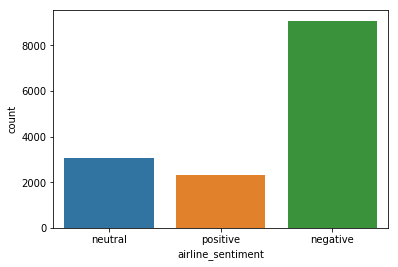

In [38]:
_ = sns.countplot(x = 'airline_sentiment', data = tweets_with_originals)

There are a lot of strategies we could try to rebalance the dataset. The easiest would be oversampling the neutral/positive sentiment tweets. 

In [43]:
from sklearn.model_selection import train_test_split
#TODO: finish this

def doc2vec_train_test_split(trained_model, doc_ids, target_vec, test_size=.3):
    '''
    returns test train using paragraph vectors for tweets 
    (lookup based on tweet_id)
    
    '''
    train_ids, test_ids = train_test_split(doc_ids, test_size = test_size)
    train_docvec_idx = trained_model.vocabulary.indexed_doctags(train_ids, trained_model.docvecs)
    test_docvec_idx = trained_model.vocabulary.indexed_doctags(test_ids, trained_model.docvecs)

    X_train = np.array([trained_model.docvecs[idx] for idx in train_docvec_idx])
    X_test = np.array([trained_model.docvecs[idx] for idx in test_docvec_idx])

    y_train = target_vec.iloc[train_docvec_idx].values
    y_test = target_vec.iloc[test_docvec_idx].values
    return X_train, X_test, y_train, y_test

In [41]:
# test split with oversampling ... try SMOTE 
from imblearn.over_sampling import SMOTE

y = tweets_with_originals.airline_sentiment.map({'negative': 0, 'neutral':1, 'positive':2})

# test_train split for TFIDF outputs 
tfidf_learning_inputs = []
for M in tfidf_input_mats:
    T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.3)
    sm = SMOTE() # smarter upsampling 
    T_train_sm, y_train_sm = sm.fit_sample(T_train, y_train.ravel())
    tfidf_learning_inputs.append([T_train_sm, T_test, y_train_sm, y_test])

In [80]:
# test_train_split for Doc2Vec outputs
#train
tweet_ids = tweets_with_originals.tweet_id.astype(str).values
doc2vec_learning_inputs = []
for model in doc2vec_models: 
    X_train, X_test, y_train, y_test = doc2vec_train_test_split(model, tweet_ids, y)
    sm = SMOTE()
    X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())
    doc2vec_learning_inputs.append([X_train_sm, X_test, y_train_sm, y_test])

We confirm that SMOTE balances the number of training samples in each class... 

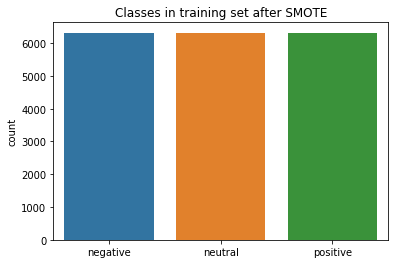

In [59]:
_ = sns.countplot(x = tfidf_learning_inputs[0][2])
_ = plt.title('Classes in training set after SMOTE')
locs, labels = plt.xticks()
_ = plt.xticks(locs, ['negative', 'neutral', 'positive'], )

## Method 1: Logistic Regression

### TF-IDF input sentiment analysis
Basic logistic regression with one-versus-rest (OVR) multiclass scheme. 

In [69]:
from sklearn.linear_model import LogisticRegression

tfidf_log_models = []
for i, ngram_model in enumerate(tfidf_learning_inputs): 
    lr = LogisticRegression(solver = 'lbfgs', multi_class='auto', max_iter = 200)
    lr.fit(ngram_model[0], ngram_model[2])
    print('{}-gram TF-IDF:\t Accuracy {}'.format(i+1,lr.score(ngram_model[1], ngram_model[3])))
    tfidf_log_models.append(lr)

1-gram TF-IDF:	 Accuracy 0.7463718037318591
2-gram TF-IDF:	 Accuracy 0.7514397604238655
3-gram TF-IDF:	 Accuracy 0.7417645703754895


### Word2Vec input sentiment analysis

We try the sum of words embedding which is described [here](https://white.ucc.asn.au/publications/White2015SentVecMeaning.pdf). We just take the sum of the word vectors contained in a tweet. 

In [127]:
def sowe_train_test_split(trained_model, doc_ids, target_vec, test_size=.3):
    # Returns test/train split: features are sums of word vectors for each tweet. 
    # doc_ids contain, for example, tweet ids 
    # target_vec is assumed to be indexed by doc_ids 
    train_ids, test_ids = train_test_split(doc_ids, test_size = test_size)
    X_train = build_sowe(trained_model, train_ids)
    X_test = build_sowe(trained_model, test_ids)
    
    y_train = target_vec.iloc[train_ids].values
    y_test = target_vec.iloc[test_ids].values

def build_sowe(trained_model, doc_ids, target_vec):
    #build sum of words embedding ML input
    pass

def wv_lookup(trained_model, word):
    # looks up word -> vec translation
    # catches error
    default_vec = np.zeros(trained_model.vector_size)
    try:
        return trained_model.wv[word]
    except:
        return default_vec

def sow_from_tweet(trained_model, tokenized_tweet):
    # Sum of words for a single tweet 
    vecs = list(map(lambda word: wv_lookup(trained_model, word), tokenized_tweet))
    return np.sum(vecs, axis=0)

In [109]:
model_word2vec.vector_size

100

In [ ]:
sow_from_w

In [126]:
np.sum(sow_from_tweet(model_word2vec, tokenized_input[0]), axis=0)

array([ 0.58956656, -1.38863343,  0.15150377,  1.02561995, -1.00322363,
        0.13215895,  0.39881968, -1.5946168 , -1.25538049, -0.04223027,
        0.15760099, -0.18143848,  0.3754073 ,  0.32879773,  0.86749344,
        0.45247516,  1.65286747, -0.9682514 ,  0.52150771, -1.18231171,
        1.28511823, -1.19363871, -0.83518154,  2.79301821,  0.22339585,
       -0.2126379 ,  0.04244782, -0.66937584,  1.38906348, -0.83325899,
        1.01568795,  1.95212466, -2.39438522, -1.99725257,  1.09375907,
       -0.53754383,  0.89119262,  0.48749726,  0.37559569, -0.73960784,
       -0.18809643, -1.86905348,  1.55215791,  1.53004739, -0.09094448,
        0.17661667,  3.17012906,  1.47410482, -0.75404444,  0.30731732,
        1.11724599,  0.97052401, -0.62809788, -1.4440279 ,  0.4480595 ,
       -0.49965289,  0.97406555,  1.61815414,  1.45777941,  0.64921694,
       -2.52974886, -0.67322816, -0.33969241, -0.76354349, -0.06020771,
       -2.12793171,  0.05130973,  0.48766083, -0.9852702 ,  0.38

### Doc2Vec input sentiment analysis

In [81]:
doc2vec_log_models = []
for i,model in enumerate(doc2vec_learning_inputs): 
    lr = LogisticRegression(solver='lbfgs', multi_class = 'auto', max_iter = 500)
    lr.fit(model[0], model[2])
    print('Model {}: \t Accuracy {}'.format(i+1, lr.score(model[1], model[3])))
    doc2vec_log_models.append(lr)

/conda/envs/nlp/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Model 1: 	 Accuracy 0.32411886662059436
Model 2: 	 Accuracy 0.5215388159410275
Model 3: 	 Accuracy 0.5143976042386547


Performance is poor here: instability was observed in results when training the various Doc2Vec models. I think that we need more training data: the number of tweets we have is pretty low for the complexity of the doc2vec NN. 

## Method 2: Random Forest